<a href="https://colab.research.google.com/github/MatthewYancey/16-9GAN/blob/master/model_gans_right_side.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16:9 Generative Model
This notebook takes images that are in a 4:3 aspect ratio and converts them to 16:9 aspect ratio.

## Imports and Parameters

In [1]:
import shutil
import glob
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# network parameters
BATCH_SIZE = 5
DATASET_SIZE = 2100
N_BATCHES = (DATASET_SIZE // BATCH_SIZE) * 2 # divide by two because we have two data loaders and the batch size is split between them
N_GPU = 1
N_WORKERS = 1
N_EPOCHS = 100
LEARNING_RATE = 0.01

# image
IMG_WIDTH = 320
IMG_HEIGHT = 180
SINGLE_SIDE = 40

# directories
ZIP_DIR = '/content/gdrive/My Drive/16:9GAN/data_out/frames_16_9.zip'
IMG_DIR = '/content/frames/'
LOG_DIR = '/content/gdrive/My Drive/16:9GAN/data_out/logs/model_002/'

# testing index
testing_index = [3]

# checkpoint type
CHECKPOINT_TYPE = 'none' # none or prev_checkpoint

In [3]:
shutil.unpack_archive(ZIP_DIR, IMG_DIR, 'zip')

## Create the Data Loaders and Load the Data

In [4]:
img_list = glob.glob(IMG_DIR + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')
img_list = img_list[:DATASET_SIZE]
print(f'Number of images for training: {len(img_list)}')

Number of images: 2143
Number of images for training: 2100


In [5]:
# a custom dataset class for reading in our images from the list
class ReadFromList(Dataset):

    def __init__(self, img_list, transform=None, mask=False):
        self.img_list = img_list
        self.transform = transform
        self.mask = mask

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = Image.open(self.img_list[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # blacks out the sides of the 16:9 image to get a 4:3 at random
        if self.mask:
            for x in range(SINGLE_SIDE):
                for y in range(IMG_HEIGHT):
                    for i in range(3): # for each channel
                        # image[i][y][x] = -1
                        image[i][y][IMG_WIDTH - 1 - x] = -1

        return image

In [6]:
# makes the dataset and data loader
dataset_gen = ReadFromList(img_list, mask=True, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataset_target = ReadFromList(img_list, mask=False, transform=transforms.Compose([
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_gen = torch.utils.data.DataLoader(dataset_gen, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=N_WORKERS)
dataloader_target = torch.utils.data.DataLoader(dataset_target, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_gen.dataset)}')

Size of dataset: 2100


In [7]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and N_GPU > 0) else "cpu")
print(f'Device: {device}')

Device: cuda:0


### Plot random images of 4:3 and 16:9

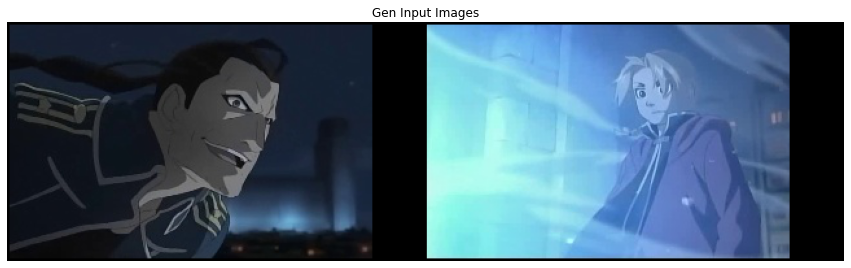

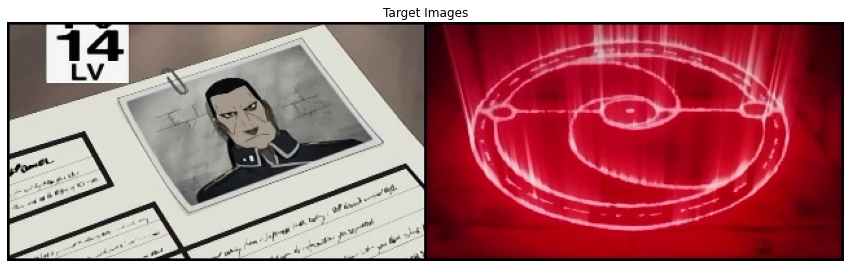

In [8]:
# Plot some training images
batch = next(iter(dataloader_gen))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Gen Input Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

batch = next(iter(dataloader_target))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

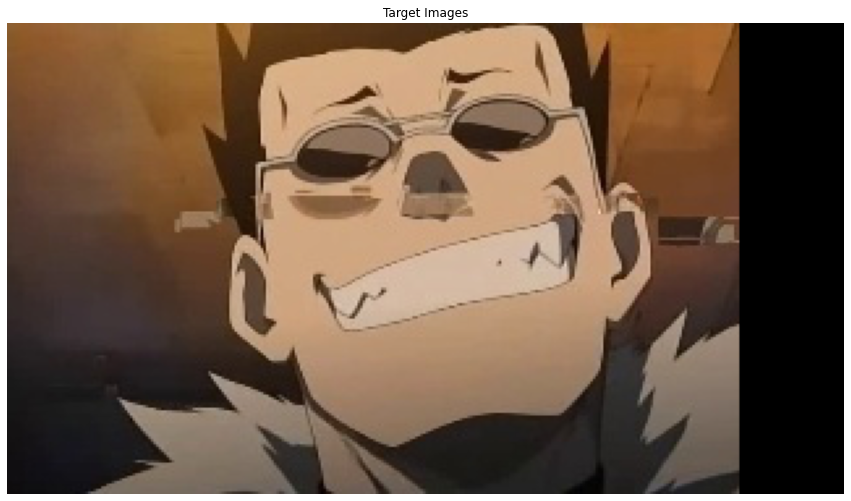

In [9]:
# Plot the image that will be logged to tensorboard
# also makes a dataloader for keeping the spot check image
dataset_spotcheck = torch.utils.data.Subset(dataset_gen, testing_index)
dataloader_spotcheck = torch.utils.data.DataLoader(dataset_spotcheck, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

batch = next(iter(dataloader_spotcheck))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

## Networks

### Generartor

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.dilconv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=2, padding=2)
        self.dilconv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=4, padding=4)
        self.dilconv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=8, padding=8)
        self.dilconv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=16, padding=16)

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv10 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

        self.batch_norm3 = nn.BatchNorm2d(3)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        # encoding
        x = self.conv1(img)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch_norm128(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # dilation
        x = self.dilconv1(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv2(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv3(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        # more encoding
        x = self.conv7(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv8(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # decoding
        x = self.deconv1(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv9(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.deconv2(x)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv10(x)
        x = self.batch_norm32(x)
        x = self.relu(x)

        # output
        x = self.conv11(x)
        x = self.tanh(x)

        # combines with the original image
        print(x.shape)
        local_gen_output = x[:, :, :, (IMG_WIDTH - SINGLE_SIDE):]
        img = img[:, :, :, :(IMG_WIDTH - SINGLE_SIDE)]
        global_gen_output = torch.cat((img, local_gen_output), 3)

        return (local_gen_output, global_gen_output)

In [47]:
try:
    del local_gen_output
except:
    pass

try:
    del global_gen_output
except:
    pass

try:
    del batch
except:
    pass

In [48]:
del gen

In [ ]:
batch = next(iter(dataloader_spotcheck))

In [18]:
local_gen_output[0][0 ]

tensor([[ 0.0153, -0.3198, -0.1439,  ..., -0.0563,  0.1040, -0.0699],
        [-0.3615, -0.0857, -0.0848,  ..., -0.0857, -0.1201,  0.0172],
        [-0.3576, -0.6452, -0.3535,  ..., -0.5305, -0.4103, -0.3632],
        ...,
        [-0.4503, -0.2772, -0.0035,  ...,  0.0193, -0.1226,  0.0847],
        [-0.5630, -0.1511, -0.3273,  ..., -0.0060, -0.3082, -0.4508],
        [ 0.0114, -0.1631, -0.1250,  ..., -0.2120, -0.0753, -0.0933]],
       device='cuda:0', grad_fn=<SelectBackward>)

torch.Size([2, 3, 180, 40])
180


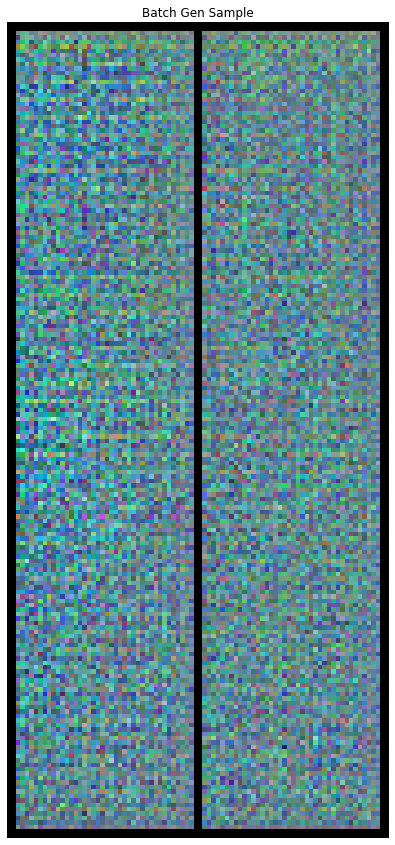

In [16]:
# batch = next(iter(dataloader_gen))
# batch = batch.cuda()
# gen = Generator(N_GPU).to(device)
# local_gen_output, global_gen_output = gen(batch)

print(local_gen_output.shape)
print(IMG_HEIGHT)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Batch Gen Sample')
plt.imshow(np.transpose(vutils.make_grid(local_gen_output.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

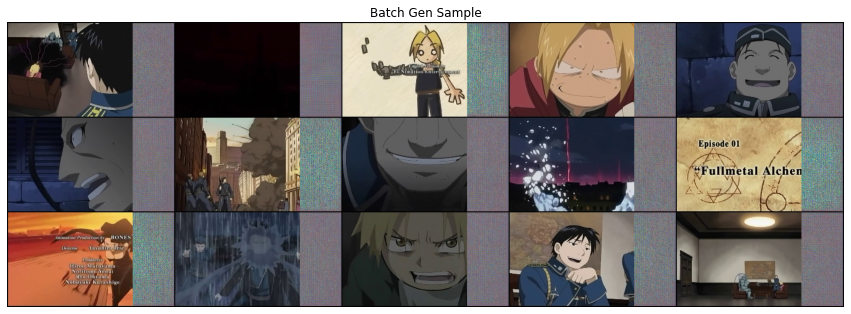

In [16]:
# what is the width of the filled in area?
print(SINGLE_SIDE)

batch = next(iter(dataloader_gen))
batch = batch.cuda()
local_gen_output, global_gen_output = gen(batch)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Batch Gen Sample')
plt.imshow(np.transpose(vutils.make_grid(global_gen_output.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

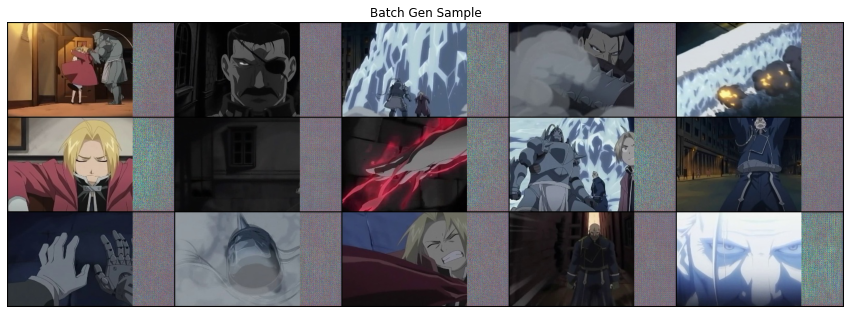

In [14]:
batch = next(iter(dataloader_gen))
batch = batch.cuda()
local_gen_output, global_gen_output = gen(batch)
# local_disc_output = local_disc(local_gen_output)
# global_disc_output = global_disc(global_gen_output)
# concat_output = concat_layer(local_disc_output, global_disc_output)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Batch Gen Sample')
plt.imshow(np.transpose(vutils.make_grid(global_gen_output.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

### Discriminators

#### Local Discriminator

In [14]:
class LocalDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(LocalDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)

        self.batch64 = nn.BatchNorm2d(64)
        self.batch128 = nn.BatchNorm2d(128)
        self.batch256 = nn.BatchNorm2d(256)
        self.batch512 = nn.BatchNorm2d(512)

        self.linear = nn.Linear(512*6*3, 1024)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch256(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = x.view(-1, 512*6*3)
        x = self.linear(x)
        x = self.relu(x)

        return x

#### Global Discriminator

In [15]:
class GlobalDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(GlobalDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)

        self.batch64 = nn.BatchNorm2d(64)
        self.batch128 = nn.BatchNorm2d(128)
        self.batch256 = nn.BatchNorm2d(256)
        self.batch512 = nn.BatchNorm2d(512)

        self.linear = nn.Linear(512*3*5, 1024)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch256(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = x.view(-1, 512*3*5)
        x = self.linear(x)
        x = self.relu(x)

        return x

#### Concatentation Layer

In [16]:
class ConcatenationLayer(nn.Module):
    def __init__(self, ngpu):
        super(ConcatenationLayer, self).__init__()
        
        self.linear = nn.Linear(2048, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_local, x_global):
        x = torch.cat((x_local, x_global), 1)
        x = self.linear(x)
        x = self.sigmoid(x)

        return x

### Initialize the Networks

In [17]:
gen = Generator(N_GPU).to(device)
local_disc = LocalDiscriminator(N_GPU).to(device)
global_disc = GlobalDiscriminator(N_GPU).to(device)
concat_layer = ConcatenationLayer(N_GPU).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (N_GPU > 1):
#     gen = nn.DataParallel(netG, list(range(N_GPU)))

gen.apply(weights_init)
local_disc.apply(weights_init)
global_disc.apply(weights_init)
concat_layer.apply(weights_init)

ConcatenationLayer(
  (linear): Linear(in_features=2048, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Testing Generator output

In [25]:
local_gen_output

<function Tensor.min>

In [31]:
torch.cuda.empty_cache()
batch = next(iter(dataloader_gen))
batch = batch.cuda()
local_gen_output, global_gen_output = gen(batch)
local_disc_output = local_disc(local_gen_output)
global_disc_output = global_disc(global_gen_output)
concat_output = concat_layer(local_disc_output, global_disc_output)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Batch Gen Sample')
plt.imshow(np.transpose(vutils.make_grid(local_gen_output.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

RuntimeError: ignored

## Training

### Loads Checkpoints

In [ ]:
if CHECKPOINT_TYPE == 'prev_checkpoint':
    # loads the model weights
    checkpoint = torch.load(LOG_DIR + 'checkpoint.pt')
    gen.load_state_dict(checkpoint['gen_state'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print('Checkpoint Loaded')
    
    # loads the epoch counter
    with open(LOG_DIR + 'itercount.txt', 'r') as f:
        batch_counter = int(f.read())
    # moves it up one becuase it's currenlty at the last epoch we did
    batch_counter += 1

elif CHECKPOINT_TYPE == 'none':
    # remove all previous logs
    try:
        shutil.rmtree(LOG_DIR)
        print('Folders removed')
    except FileNotFoundError:
        print('No log folder found')

    batch_counter = 1

else:
    print('Failed to specify a type')

Folders removed


### Function for saving checkpoints on the model

In [ ]:
def checkpoint(epoch, i, batch_counter, loss_value):
    print(f'Epoch: {epoch}/{N_EPOCHS}, Batch in Epoch: {i}/{N_BATCHES}, Total Images {batch_counter * BATCH_SIZE}, Loss: {loss_value:.2f}')

    # saves everything once every epoch
    if i == 0:
        # saves loss to the tensorboard log    
        writer.add_scalar('Loss/Training', loss_value.item(), batch_counter)

        # saves a checkpoint
        checkpoint = {'gen_state': gen.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, LOG_DIR + 'checkpoint.pt')

        # Saves an image so we can view the progression
        test_inputs = next(iter(dataloader_spotcheck))
        test_inputs = test_inputs.cuda()
        with torch.no_grad():
            output = gen(test_inputs)[1]
        grid = torchvision.utils.make_grid(output, normalize=True)
        writer.add_image('image_epoch_%d' % batch_counter, grid)

        # saves the epoch counter
        with open(LOG_DIR + '/itercount.txt', 'w') as f:
            f.write(str(batch_counter))
        
        print('Saved checkpoint')

### Loss Function and Optimizer

In [ ]:
loss = nn.MSELoss()
optimizer = optim.SGD(gen.parameters(), lr=LEARNING_RATE, momentum=0.9)

### Training Loop

In [ ]:
writer = SummaryWriter(LOG_DIR)

# trianing loop
for epoch in range(N_EPOCHS):

    running_loss = 0
    target_iter = iter(dataloader_target)
    for i, batch_gen in enumerate(dataloader_gen):
        batch_target = next(iter(dataloader_target))
        
        # moves the images to the GPU
        batch_gen = batch_gen.cuda()
        batch_target = batch_target.cuda()

        # feeds the generator
        gen_local_output, gen_global_output = gen(batch_gen.cuda())

        # passes in the generated images
        local_disc_output = local_disc(gen_local_output)
        global_disc_output = global_disc(gen_global_output)
        concat_output_gen = concat_layer(local_disc_output, global_disc_output)

        # passes in the authentic images
        local_disc_output = local_disc(batch_target[:, :, :, 250:])
        global_disc_output = global_disc(batch_target)
        concat_output_target = concat_layer(local_disc_output, global_disc_output)

        # concatenates the outputs
        concat_output = torch.cat((concat_output_gen, concat_output_target), 0)

        # calcualtes the loss and optimizes
        targets = torch.tensor([[0.0]]*(BATCH_SIZE//2) + [[1.0]]*(BATCH_SIZE//2)).cuda()
        loss_value = loss(concat_output, targets)
        loss_value.backward()
        optimizer.step()

        # checkpoints and print statistics every 10 batches
        if i % 10 == 0:
            checkpoint(epoch, i, batch_counter, loss_value)
        
        batch_counter += 1
        
writer.close()

Epoch: 0/100, Batch in Epoch: 0/140, Total Images 30, Loss: 0.25
Saved checkpoint
Epoch: 0/100, Batch in Epoch: 10/140, Total Images 330, Loss: 0.23
Epoch: 0/100, Batch in Epoch: 20/140, Total Images 630, Loss: 0.20
Epoch: 0/100, Batch in Epoch: 30/140, Total Images 930, Loss: 0.19
Epoch: 0/100, Batch in Epoch: 40/140, Total Images 1230, Loss: 0.20
Epoch: 0/100, Batch in Epoch: 50/140, Total Images 1530, Loss: 0.20
Epoch: 0/100, Batch in Epoch: 60/140, Total Images 1830, Loss: 0.19
Epoch: 0/100, Batch in Epoch: 70/140, Total Images 2130, Loss: 0.21
Epoch: 0/100, Batch in Epoch: 80/140, Total Images 2430, Loss: 0.20
Epoch: 0/100, Batch in Epoch: 90/140, Total Images 2730, Loss: 0.21
Epoch: 0/100, Batch in Epoch: 100/140, Total Images 3030, Loss: 0.21
Epoch: 0/100, Batch in Epoch: 110/140, Total Images 3330, Loss: 0.21
Epoch: 0/100, Batch in Epoch: 120/140, Total Images 3630, Loss: 0.20
Epoch: 0/100, Batch in Epoch: 130/140, Total Images 3930, Loss: 0.22
Epoch: 1/100, Batch in Epoch: 0/1

KeyboardInterrupt: ignored